In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import xskillscore as xs
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.cm as mpl_cm



from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


# Fog data

In [2]:
fogData = xr.open_dataset('../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
yAll=yAll/25.0
yWd= yAll[yAll >0.44]
#yWd

# 500Z Data

In [3]:
z500Data = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
z500Data
z=z500Data.z.shift(time=1)
z.values=z.values/9.81
#z

# Calculate daily Anomaly

In [4]:
da = z.assign_coords(month_day=z.time.dt.strftime("%m-%d"))
dailyAnomZ = da.groupby("month_day") - da.groupby("month_day").mean("time")
decJanAnomz=dailyAnomZ[(dailyAnomZ.time.dt.month>11) | (dailyAnomZ.time.dt.month<2)].sel(time=slice('1980-1-1','2014-12-31'))
yAll['time'] = decJanAnomz.time

In [5]:
# get WFD daily anomaly
wfdZ=decJanAnomz[yAll >0.44,:,:]
wfdZ=decJanAnomz.sel(latitude=slice(40,10),longitude=slice(50,100))[yAll >0.44,:,:]

In [6]:
X=wfdZ.stack(z=( "latitude","longitude"))
X

<xarray.DataArray 'z' (time: 478, z: 416)>
array([[-1.31416992e+02, -1.21483887e+02, -1.03985840e+02, ...,
        -3.54003906e-01, -1.16210938e-01, -2.80273438e-01],
       [-1.30867188e+02, -1.30786133e+02, -1.26186035e+02, ...,
         1.80615234e+00,  2.44824219e+00,  2.19140625e+00],
       [-1.31992188e+02, -1.25114258e+02, -1.16458984e+02, ...,
         4.94140625e+00,  4.82763672e+00,  4.69726562e+00],
       ...,
       [ 1.31127930e+01,  2.10371094e+01,  3.23203125e+01, ...,
         2.57617188e+00,  1.69433594e+00,  1.21435547e+00],
       [ 1.25288086e+01,  1.06586914e+01,  1.07812500e+01, ...,
        -6.32568359e+00, -6.08642578e+00, -6.29833984e+00],
       [ 4.45512695e+01,  3.88012695e+01,  3.25400391e+01, ...,
        -7.98242188e+00, -6.75585938e+00, -4.07958984e+00]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-04T09:00:00 ... 2014-12-31T09:00:00
    month_day  (time) object '01-04' '01-05' '01-06' ... '12-29' '12-30' '12-31'
  * z          (z) MultiIndex
  - latitude   (z) float64 40.0 40.0 40.0 40.0 40.0 ... 10.0 10.0 10.0 10.0 10.0
  - longitude  (z) float64 50.0 52.0 54.0 56.0 58.0 ... 94.0 96.0 98.0 100.0

# kmean number of clusteres

In [7]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [8]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 781.5584317899398
2 : 658.9602582365775
3 : 619.6796499629254
4 : 589.4289259615009
5 : 567.6118432879533
6 : 552.5264243220424
7 : 536.4811638926814
8 : 527.0360788360064
9 : 516.6101715304312


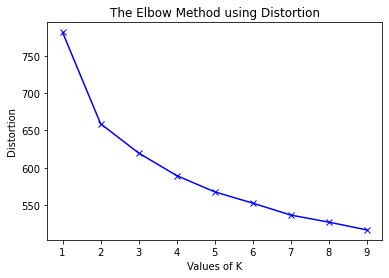

In [9]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [10]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 325944960.0
2 : 229179776.0
3 : 199657664.0
4 : 180168464.0
5 : 165972320.0
6 : 157251248.0
7 : 149117712.0
8 : 142821600.0
9 : 136364832.0


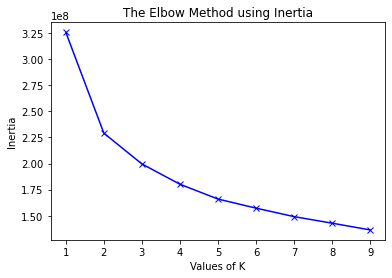

In [11]:

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Kmeans with 6 clusters

In [120]:
kmeanModel = KMeans(n_clusters=6).fit(X)
kmeanModel.fit(X)
labels=kmeanModel.labels_
labels

array([0, 0, 0, 0, 3, 3, 3, 3, 1, 2, 5, 2, 4, 2, 2, 0, 4, 4, 4, 4, 4, 0,
       5, 4, 2, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 2, 1, 1, 3, 0,
       0, 0, 0, 3, 2, 1, 1, 1, 3, 0, 3, 0, 0, 2, 3, 3, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 0, 0, 0,
       3, 4, 4, 4, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 0, 5, 5, 2, 2, 2,
       4, 2, 2, 5, 5, 3, 4, 4, 4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 0,
       3, 1, 3, 3, 5, 5, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4, 2,
       3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 4, 0, 0, 4, 4,
       2, 2, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 3, 1, 1, 3, 3, 2, 3,
       2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 4,
       4, 4, 4, 2, 0, 0, 2, 2, 2, 1, 5, 1, 1, 5, 5, 0, 0, 0, 0, 3, 1, 1,
       1, 1, 1, 1, 1, 5, 2, 2, 2, 2, 0, 3, 3, 3, 1,

In [121]:
X_lab = X.assign_coords(cluster_ids=("time", labels))
X_lab
nDays=X_lab.groupby("cluster_ids").count(dim="time")
zClust=X_lab.unstack()
zClust
nDays[:,0]

<xarray.DataArray 'z' (cluster_ids: 6)>
array([ 41,  82, 107, 111,  88,  49])
Coordinates:
    z            object (40.0, 50.0)
  * cluster_ids  (cluster_ids) int64 0 1 2 3 4 5

Text(0.5, 1.0, 'eof1')

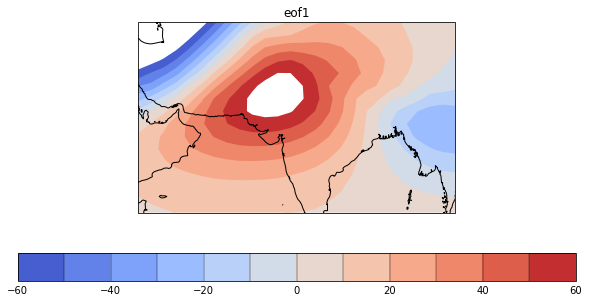

In [122]:
eof=zClust.groupby("cluster_ids").mean(dim="time")
#print(eof[0,:,:])


# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof1=eof[0,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof1,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof1")


Text(0.5, 1.0, 'eof2')

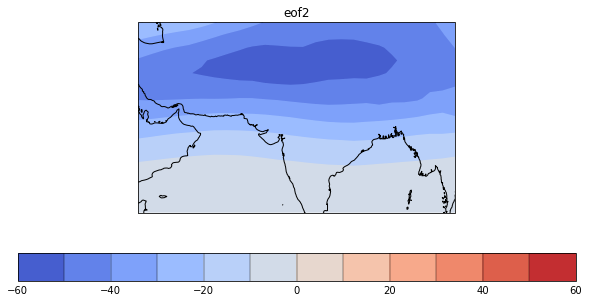

In [123]:
# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof2=eof[1,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof2,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof2")

Text(0.5, 1.0, 'eof3')

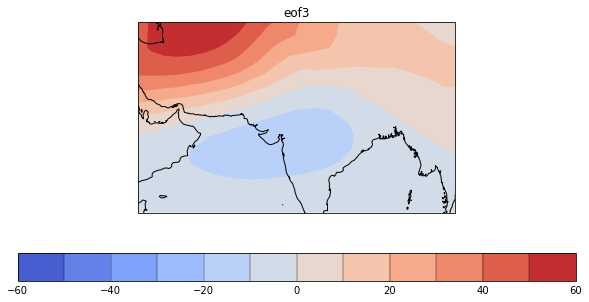

In [124]:
# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof3=eof[2,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof3,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof3")

Text(0.5, 1.0, 'eof4')

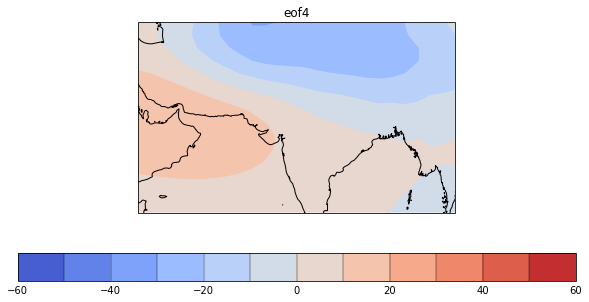

In [125]:
# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof4=eof[3,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof4,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof4")

Text(0.5, 1.0, 'eof5')

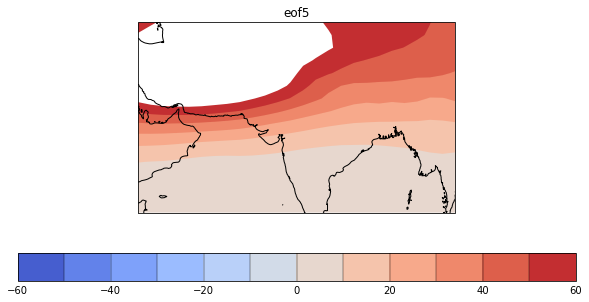

In [126]:
# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof5=eof[4,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof5,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof5")

Text(0.5, 1.0, 'eof6')

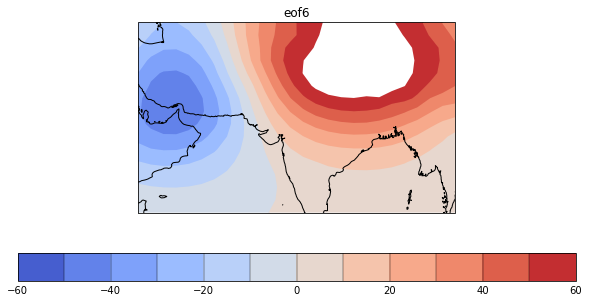

In [127]:
# plot eofs
levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
# Plot #1: contourf with axes longitude from -180 to 180
eof6=eof[5,:,:].to_iris()
#print(eof1)

#eof[0,:,:].plot()
plt.figure(figsize=(10,5))
#plt.subplot(321)
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eof6,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof6")